In [19]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
options(repr.matrix.max.rows = 6)

In [20]:
players  <- read_csv("data/players.csv")
players
sessions <- read_csv("data/sessions.csv")
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


I am trying to do Busy Hour Probabilities, where to predict which hour windows are likely to be "busy" so the server team can plan capacity

In [24]:
n_players  <- nrow(players);  n_sessions <- nrow(sessions)
names(players); names(sessions)
n_players; n_sessions

# means for numeric columns in players.csv (round to 2 d.p.)
players_means <- players |>
  summarise(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2)))
players_means

[1] "experience"   "subscribe"    "hashedEmail"  "played_hours" "name"        
[6] "gender"       "Age"

[1] "hashedEmail"         "start_time"          "end_time"           
[4] "original_start_time" "original_end_time"   "start_time_parsed"  
[7] "end_time_parsed"     "session_mins"

[1] 196

[1] 1533

played_hours,Age
<dbl>,<dbl>
5.85,21.14


In [26]:
fmt <- "%d/%m/%Y %H:%M"

sessions$start_time_parsed <- as.POSIXct(sessions$start_time, format = fmt, tz = "UTC")
sessions$end_time_parsed   <- as.POSIXct(sessions$end_time,   format = fmt, tz = "UTC")

# keep only rows we could parse; compute duration in minutes
sessions <- sessions |>
  filter(!is.na(start_time_parsed), !is.na(end_time_parsed)) |>
  mutate(session_mins = as.numeric(difftime(end_time_parsed, start_time_parsed, units = "mins")))

player_sessions_long <- sessions |>
  left_join(players, by = "hashedEmail")
player_sessions_long

hashedEmail,start_time,end_time,original_start_time,original_end_time,start_time_parsed,end_time_parsed,session_mins,experience,subscribe,played_hours,name,gender,Age
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12,2024-06-30 18:12:00,2024-06-30 18:24:00,12,Regular,TRUE,223.1,Hiroshi,Male,17
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12,2024-06-17 23:33:00,2024-06-17 23:46:00,13,Amateur,TRUE,53.9,Alex,Male,17
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12,2024-07-25 17:34:00,2024-07-25 17:57:00,23,Amateur,TRUE,150.0,Delara,Female,16
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12,2024-07-28 15:36:00,2024-07-28 15:57:00,21,Amateur,TRUE,56.1,Dana,Male,23
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12,2024-07-25 06:15:00,2024-07-25 06:22:00,7,Amateur,TRUE,56.1,Dana,Male,23
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12,2024-05-20 02:26:00,2024-05-20 02:45:00,19,Amateur,TRUE,53.9,Alex,Male,17


In [27]:
player_sessions_long$hour_bin <- as.POSIXct(
  format(player_sessions_long$start_time_parsed, "%Y-%m-%d %H:00:00"),
  tz = "UTC"
)

# count players per hour (session starts as a proxy)
hourly <- player_sessions_long |>
  group_by(hour_bin) |>
  summarise(n_players = n(), .groups = "drop") |>
  arrange(hour_bin)

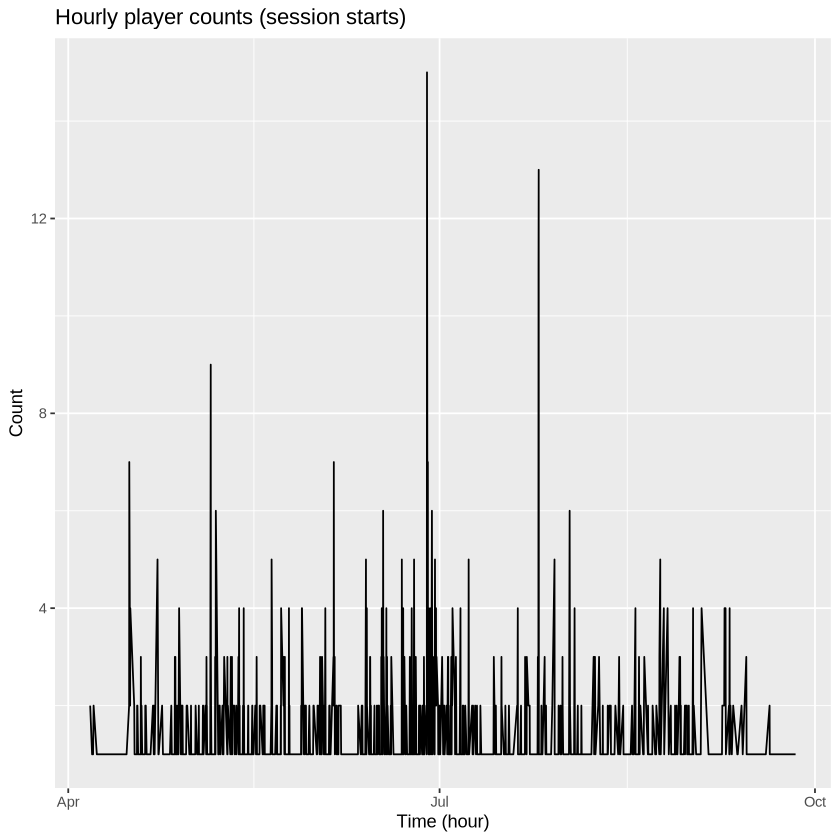

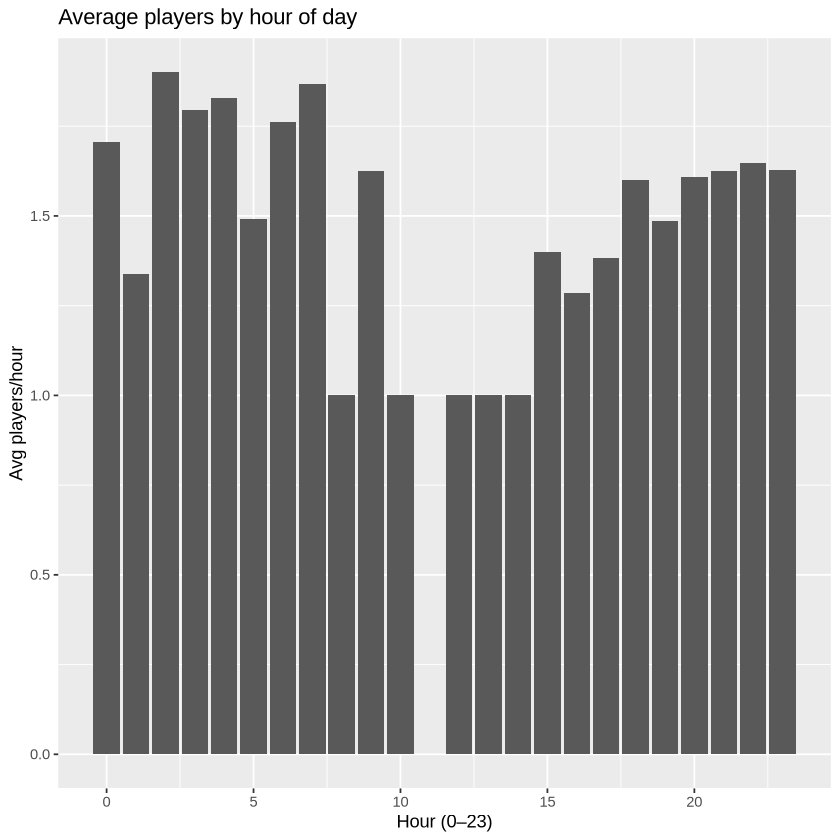

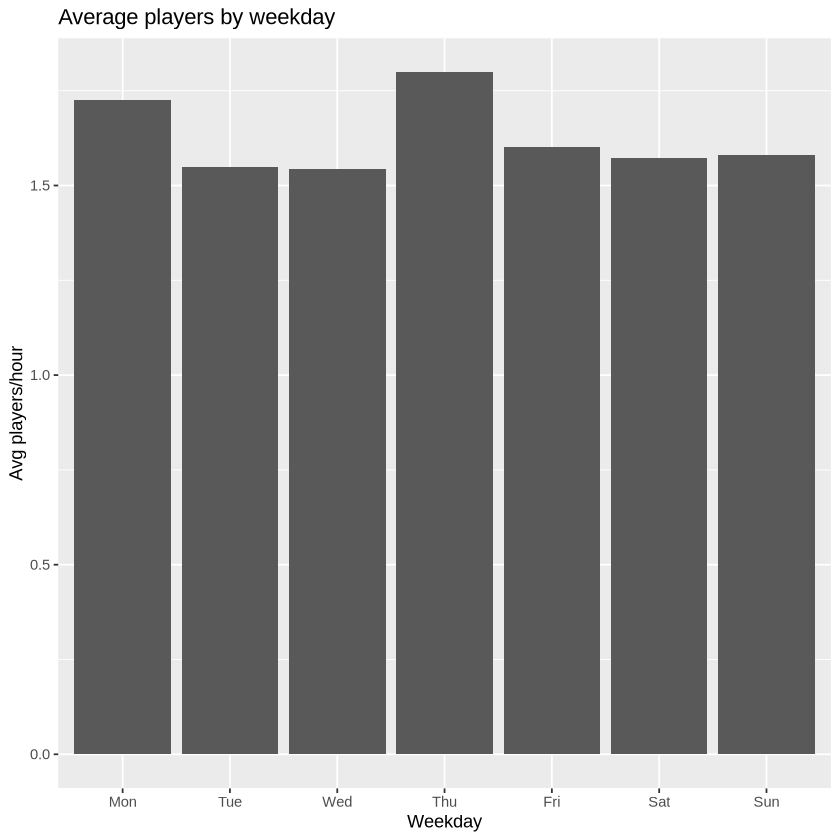

In [28]:
ggplot(hourly, aes(x = hour_bin, y = n_players)) +
  geom_line() +
  labs(title = "Hourly player counts (session starts)", x = "Time (hour)", y = "Count")

# 5.2 average by hour-of-day (bar)
hourly$hour <- as.integer(format(hourly$hour_bin, "%H"))
avg_by_hour <- hourly |>
  group_by(hour) |>
  summarise(avg_players = mean(n_players, na.rm = TRUE), .groups = "drop")

ggplot(avg_by_hour, aes(x = hour, y = avg_players)) +
  geom_col() +
  labs(title = "Average players by hour of day", x = "Hour (0–23)", y = "Avg players/hour")

# 5.3 average by weekday (bar)
# weekday label: 1=Sunday, 2=Monday, ... base R style; we can relabel lightly
hourly$dow_num <- as.integer(format(hourly$hour_bin, "%u"))  # 1=Mon,...7=Sun
labs_dow <- c("Mon","Tue","Wed","Thu","Fri","Sat","Sun")

avg_by_dow <- hourly |>
  group_by(dow_num) |>
  summarise(avg_players = mean(n_players, na.rm = TRUE), .groups = "drop")

ggplot(avg_by_dow, aes(x = factor(dow_num, labels = labs_dow), y = avg_players)) +
  geom_col() +
  labs(title = "Average players by weekday", x = "Weekday", y = "Avg players/hour")

n_hours     n_busy share_busy 
   947.000    209.000      0.221

hour,h_mean,h_sd,thresh
<int>,<dbl>,<dbl>,<dbl>
0,1.706667,0.8015750,2.107454
1,1.338983,0.6327327,1.655349
2,1.900000,1.1318183,2.465909
⋮,⋮,⋮,⋮
7,1.866667,2.2550072,2.994170
8,1.000000,0.0000000,1.000000
9,1.625000,0.9161254,2.083063


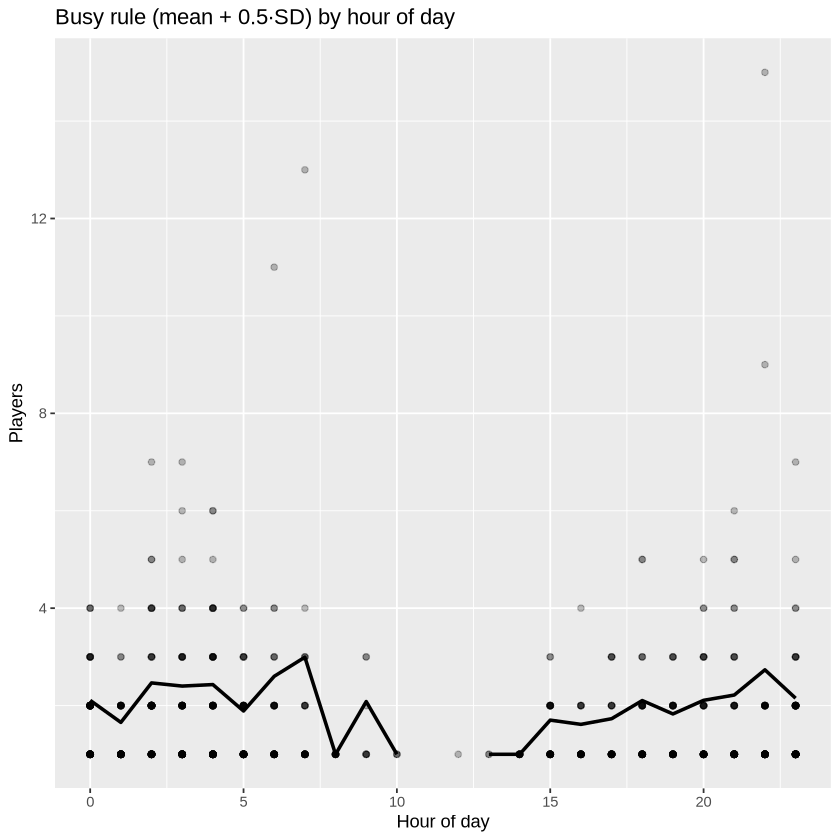

always_not_busy_accuracy                busy_rate 
                      NA                       NA

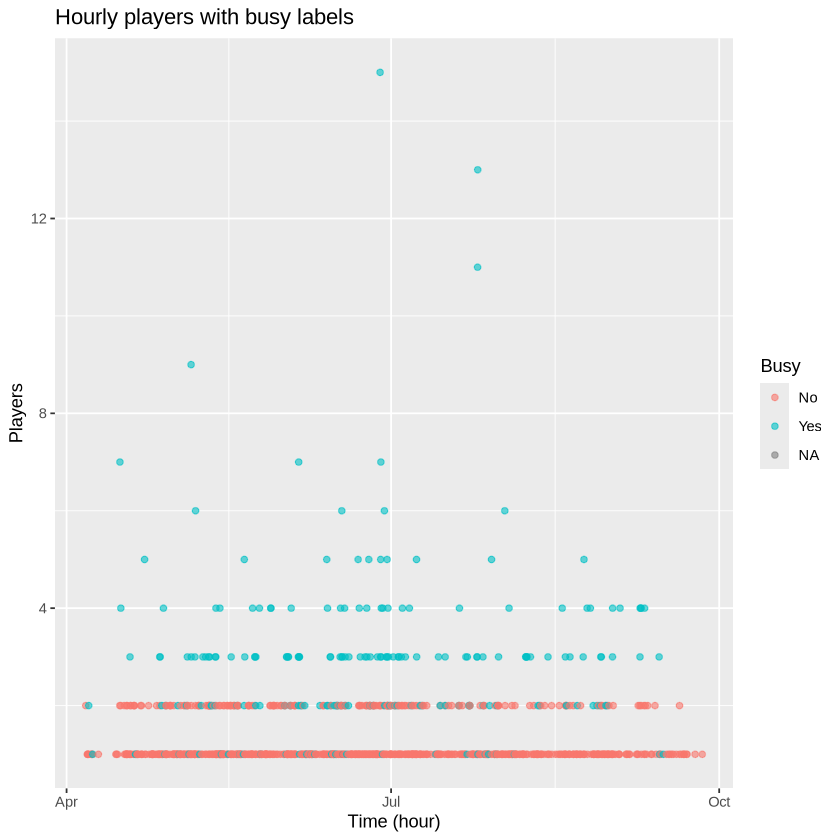

In [30]:
# compute mean and sd for each hour of day
hour_stats <- hourly |>
  group_by(hour) |>
  summarise(h_mean = mean(n_players, na.rm = TRUE),
            h_sd   = sd(n_players,   na.rm = TRUE),
            .groups = "drop") |>
  mutate(thresh = h_mean + 0.5 * h_sd)  # tune 0.5 to 1.0 as needed

# join threshold back and label busy
df <- hourly |>
  left_join(hour_stats, by = "hour") |>
  mutate(busy = as.integer(n_players >= thresh))

# How many hours and what share are labeled busy?
n_hours <- nrow(df)
n_busy  <- sum(df$busy, na.rm = TRUE)
share_busy <- round(n_busy / n_hours, 3)
c(n_hours = n_hours, n_busy = n_busy, share_busy = share_busy)

# Typical threshold by hour (table you can screenshot)
head(hour_stats[ , c("hour","h_mean","h_sd","thresh")], 10)
ggplot(df, aes(hour, n_players)) +
  geom_point(alpha = 0.25) +
  geom_line(data = hour_stats, aes(hour, thresh), linewidth = 1) +
  labs(title = "Busy rule (mean + 0.5·SD) by hour of day",
       x = "Hour of day", y = "Players")

# Time series with points colored by busy/not-busy
ggplot(df, aes(hour_bin, n_players, color = factor(busy))) +
  geom_point(alpha = 0.6) +
  scale_color_discrete(name = "Busy", labels = c("No","Yes")) +
  labs(title = "Hourly players with busy labels",
       x = "Time (hour)", y = "Players")
# Baseline that never flags busy
always_not_busy_accuracy <- mean(df$busy == 0)

# Your rule’s positive rate (how often it flags)
busy_rate <- mean(df$busy)

c(always_not_busy_accuracy = round(always_not_busy_accuracy, 3),
  busy_rate = round(busy_rate, 3))

Planning Report — Busy Hour Probability

Data description: We use two tables: players.csv (one row per player) and sessions.csv (one row per session). After parsing timestamps, we compute session durations and aggregate session starts into hourly counts. The dataset contains N_hour hourly observations. The mean of numeric columns in players.csv is summarized in a small table.

Questions:
Broad: Question 3 "We are interested in demand forecasting, namely, what time windows are most likely to have large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability."
Specific: Can hour-of-day and weekday patterns help identify “busy” hours?

Exploratory analysis. A simple time-series plot shows clear daily cycles and weekly structure. Averaging by hour-of-day, activity peaks around peak hours, like, 18–22 and is lowest near off-hours. Averaging by weekday, days are typically busier than days. These patterns suggest that stable daily/weekly seasonality explains much of the variation.

To respect daily cycles, I define a context-dependent threshold for each hour of day: Where busy if n(players) >= μ(hour) + 0.5*σ(hour), where μ(hour) and σ(hour) are the historical mean and standard deviation of counts at that hour (computed from the data). Using this rule, n_busy of N_hours (share_busy %) are labeled busy.

Method and plan. This hour-baseline rule is simple, transparent, and grounded in the observed seasonality. For a modeling extension, I would fit a logistic regression (busy vs. not busy) using hour, weekday, and recent level (e.g., a short moving average) as features. I would use a time-based split (earlier hours for training, later hours for validation) and report probability quality (e.g., Brier score) and a confusion matrix at a reasonable threshold. A basic non-learning baseline is “always not busy.”

Assumptions and limitations. Session starts per hour approximate concurrent usage; timestamps are consistently parsed. Special events or outages may break stationarity; missing logs may undercount activity. The 0.5*σ margin can be tuned.